In [35]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('OnlineRetail.csv')

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
df_user = pd.DataFrame(df['CustomerID'].unique())

In [5]:
df_user.columns = ['CustomerID']

In [14]:
uk_df = df.query("Country == 'United Kingdom'").reset_index(drop = True)

## Recency

In [21]:
recent_purchase_df = uk_df.groupby("CustomerID").InvoiceDate.max().reset_index()

In [22]:
recent_purchase_df.columns =  ['CustomerID','MaxPurchaseDate']

In [27]:
recent_purchase_df['Recency'] = (recent_purchase_df['MaxPurchaseDate'].max() - recent_purchase_df['MaxPurchaseDate']).dt.days

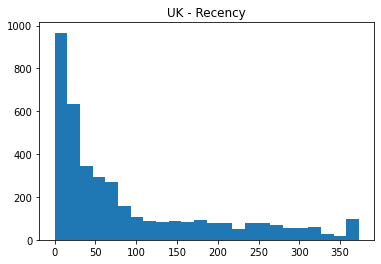

In [31]:
plt.hist(recent_purchase_df['Recency'],bins='auto')
plt.title("UK - Recency")
plt.show()

In [33]:
df_user = pd.merge(df_user, recent_purchase_df[['CustomerID','Recency']], on='CustomerID')

In [34]:
df_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


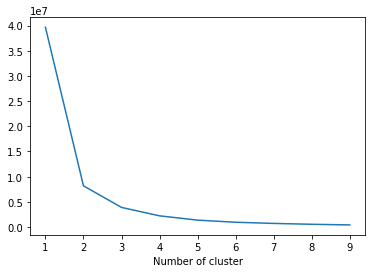

In [36]:
sse={}
tx_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

- 3개가 적당하지만 비지니스 요구에 기반하여 4개로 한다.

In [38]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [41]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [43]:
df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [61]:
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.0,373.0
1,570.0,184.436842,31.856230,131.0,156.00,184.0,211.0,244.0
2,952.0,77.567227,22.743569,48.0,59.00,72.0,93.0,130.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0


## Frequency

In [65]:
tx_frequency = uk_df.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [69]:
df_user = pd.merge(df_user,tx_frequency,on = 'CustomerID')

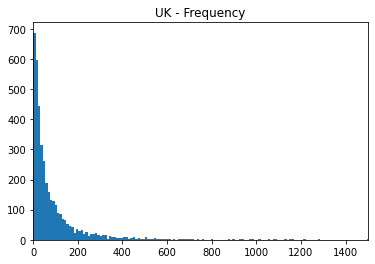

In [78]:
plt.hist(df_user['Frequency'],bins='auto')
plt.title("UK - Frequency")
plt.xlim([0,1500])
plt.show()

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [89]:
df_user = order_cluster('FrequencyCluster','Frequency',df_user,True)

In [91]:
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3495.0,49.485551,44.897776,1.0,15.00,33.0,73.0,189.0
1,430.0,330.893023,133.873745,190.0,227.25,287.0,398.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.50,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.00,5128.0,6555.5,7983.0


## Revenue

In [95]:
uk_df['Revenue'] = uk_df['UnitPrice'] * uk_df['Quantity']

In [101]:
df_user = pd.merge(df_user,uk_df.groupby('CustomerID')['Revenue'].sum().reset_index(),on='CustomerID')

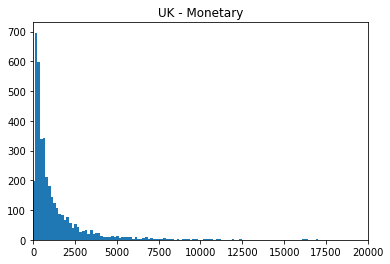

In [105]:
plt.hist(df_user['Revenue'],bins = 'auto')
plt.title("UK - Monetary")
plt.xlim([0,20000])
plt.show()

In [107]:
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])

In [108]:
df_user.groupby("RevenueCluster")['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3686.0,906.329979,920.325222,-4287.63,262.8975,572.5055,1257.5925,4301.22
1,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.3300,239199.4100,256438.49
2,27.0,43070.445185,15939.249588,25748.35,28865.4900,36351.4200,53489.7900,88125.38
3,235.0,7746.035787,3636.348298,4314.72,5152.9650,6530.0400,9116.7900,21535.90


In [111]:
df_user = order_cluster('RevenueCluster','Revenue',df_user,True)

In [112]:
df_user.groupby("RevenueCluster")['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3686.0,906.329979,920.325222,-4287.63,262.8975,572.5055,1257.5925,4301.22
1,235.0,7746.035787,3636.348298,4314.72,5152.9650,6530.0400,9116.7900,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.4900,36351.4200,53489.7900,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.3300,239199.4100,256438.49


In [113]:
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.170213,32.569149,499.035215
2,78.870229,47.044711,864.548497
3,20.729318,68.304434,1092.971126
4,14.929766,271.481605,3601.606990
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


In [114]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value' 

<AxesSubplot:xlabel='Frequency', ylabel='Revenue'>

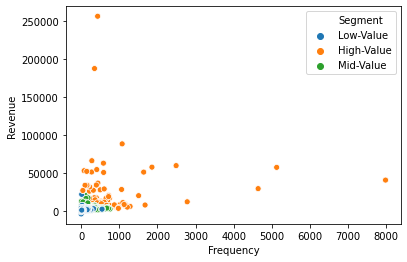

In [116]:
sns.scatterplot(x = 'Frequency',y = 'Revenue',data=df_user,hue='Segment')

<AxesSubplot:xlabel='Recency', ylabel='Revenue'>

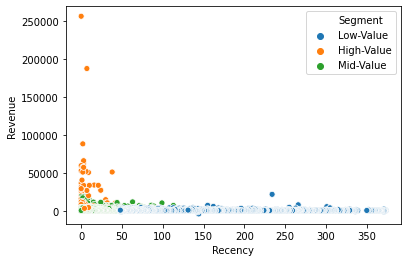

In [117]:
sns.scatterplot(x = 'Recency',y = 'Revenue',data=df_user,hue='Segment')